In [36]:
## Libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import zipfile

from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import Input

from PIL import Image

In [37]:
base_dir = "../input/14-celebrity-faces-dataset"
celeb14 = os.path.join(base_dir, "14-celebrity-faces-dataset.zip")

with zipfile.ZipFile(celeb14, "r") as z:
    z.extractall('.')

In [39]:
path = "/kaggle/working/14-celebrity-faces-dataset/data"
dir_list = os.listdir(path)

print(dir_list)

['train', 'val']


In [40]:
train_dir = path+ "/" + dir_list[0]
print(train_dir)

train_list = os.listdir(train_dir)
print(train_list)

train_data = []
label = []
for i in range(len(train_list)):
    celebrity_list = os.listdir(train_dir + "/" + train_list[i])
 
    for j in range(len( celebrity_list)):
        cel_list = train_dir + "/" + train_list[i]+ "/" + celebrity_list[j]
        img = Image.open(cel_list).convert('RGB')
        train_data.append(img)
        label.append(train_list[i])

/kaggle/working/14-celebrity-faces-dataset/data/train
['elton_john', 'sofia_vergara', 'simon_pegg', 'dwayne_johnson', 'lauren_cohan', 'kate_beckinsale', 'anne_hathaway', 'ben_afflek', 'keanu_reeves', 'will_smith', 'madonna', 'mindy_kaling', 'jerry_seinfeld', 'arnold_schwarzenegger']


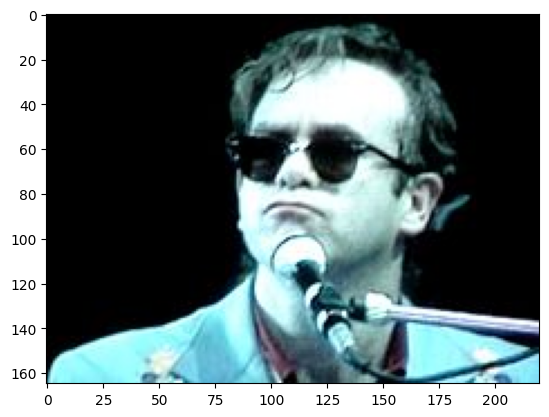

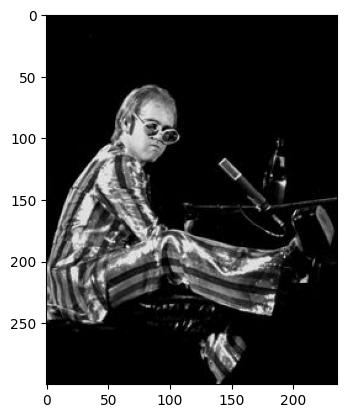

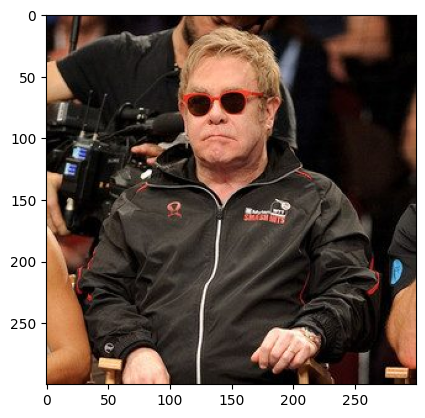

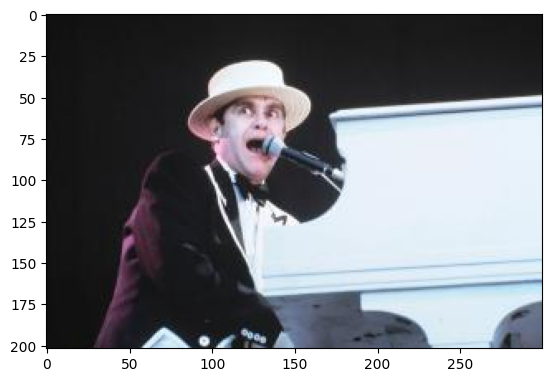

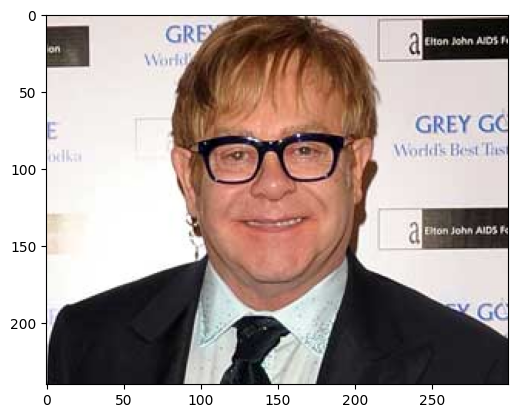

In [41]:
## See data
for i in range(5):
    plt.imshow(train_data[i])
    plt.show()

<h3> Pre-processing </h3>

In [42]:
print("Total data training: ", len(train_data))

t_data = []
for i in range(len(train_data)):
    im = train_data[i].resize((200,200))
## Data normalization
    im = np.array(im) / 255.0
    t_data.append(im)

Total data training:  220


(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


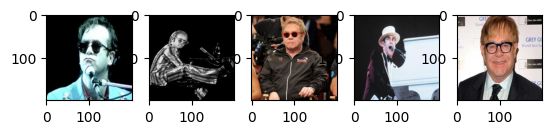

In [43]:
for i in range(5):
    print(np.shape(t_data[i]))
    plt.subplot(1,5,i+1)
    plt.imshow(t_data[i])
plt.show()

In [44]:
le = preprocessing.LabelEncoder()
le.fit(label)
labels1 = le.transform(label)
labels2 = tf.keras.utils.to_categorical(labels1)

In [45]:
val_dir = path+ "/" + dir_list[1]
print(val_dir)

val_list = os.listdir(val_dir)
print(val_list)

val_data = []
v_label = []
for i in range(len(val_list)):
    val_famoso_list = os.listdir(val_dir + "/" + val_list[i])
    for j in range(len(val_famoso_list)):
        val_fam_list = val_dir + "/" + val_list[i]+ "/" + val_famoso_list[j]
        img = Image.open(val_fam_list).convert('RGB')   
        val_data.append(img)
        v_label.append(val_list[i])

/kaggle/working/14-celebrity-faces-dataset/data/val
['elton_john', 'sofia_vergara', 'simon_pegg', 'dwayne_johnson', 'lauren_cohan', 'kate_beckinsale', 'anne_hathaway', 'ben_afflek', 'keanu_reeves', 'will_smith', 'madonna', 'mindy_kaling', 'jerry_seinfeld', 'arnold_schwarzenegger']


In [46]:
v_data = []
for i in range(len(val_data)):
    im = val_data[i].resize((200,200))
## Data Normalization 
    im = np.array(im) / 255.0
    v_data.append(im)

In [47]:
v_labels1 = le.transform(v_label)
v_labels2 = tf.keras.utils.to_categorical(v_labels1)

In [48]:
input_shape = (200,200,3)

densenet = tf.keras.applications.DenseNet201(  
    weights='imagenet',
    include_top=False,
    input_shape=input_shape)

for layer in densenet.layers:
    layer.trainable = False

densenet.trainable = False
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(4096, activation='relu')) #sigmoid
    model.add(Dropout(0.2))
    model.add(Dense(14, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(lr=1e-4), #1e-4
        metrics=['categorical_accuracy'])
     
    return model

modelo = build_model()

In [49]:
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 6, 6, 1920)        18321984  
                                                                 
 global_average_pooling2d_1   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 4096)              7868416   
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 14)                57358     
                                                                 
Total params: 26,247,758
Trainable params: 7,925,774
Non-trainable params: 18,321,984
__________________________________

In [50]:
for i in range(len(t_data)):
    if t_data[i].shape != (200,200,3):
        print(i)
        t_data[i] = t_data[i][:,:,:3]
        print(t_data[i].shape)
        
for i in range(len(v_data)):
    if v_data[i].shape != (200,200,3):
        print(i)
        v_data[i] = v_data[i][:,:,:3]
        print(v_data[i].shape)

In [51]:
modelo.compile(optimizer = 
               tf.keras.optimizers.Adam(learning_rate=0.01), 
               loss=tf.keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy'])

In [52]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="D_epoch.{epoch:02d}-{val_loss:.2f}.h5",
    save_weights_only=False,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

In [53]:
x_train, x_test, y_train, y_test = train_test_split(
                                    t_data, 
                                    labels2, 
                                    test_size=0.10, 
                                    random_state=42)

In [54]:
# history = modelo.fit(np.array(t_data), np.array(labels2), batch_size= 100, epochs = 80, validation_data=(np.array(v_data),np.array(v_labels2)),callbacks=[model_checkpoint_callback])
history = modelo.fit(np.array(x_train), np.array(y_train), batch_size= 10, epochs = 100, validation_data=(np.array(v_data),np.array(v_labels2)),callbacks=[model_checkpoint_callback])

Epoch 1/100
20/20 [==============================] - 45s 2s/step - loss: 36.2383 - accuracy: 0.1061 - val_loss: 3.8436 - val_accuracy: 0.2143
Epoch 2/100
20/20 [==============================] - 28s 1s/step - loss: 2.1303 - accuracy: 0.3586 - val_loss: 2.1546 - val_accuracy: 0.2857
Epoch 3/100
20/20 [==============================] - 28s 1s/step - loss: 1.4855 - accuracy: 0.4949 - val_loss: 1.8363 - val_accuracy: 0.4286
Epoch 4/100
20/20 [==============================] - 28s 1s/step - loss: 1.1903 - accuracy: 0.5960 - val_loss: 2.3680 - val_accuracy: 0.3571
Epoch 5/100
20/20 [==============================] - 24s 1s/step - loss: 0.8690 - accuracy: 0.7727 - val_loss: 2.1126 - val_accuracy: 0.4857
Epoch 6/100
20/20 [==============================] - 27s 1s/step - loss: 0.9079 - accuracy: 0.7475 - val_loss: 2.0454 - val_accuracy: 0.5000
Epoch 7/100
20/20 [==============================] - 23s 1s/step - loss: 0.4115 - accuracy: 0.8535 - val_loss: 2.2825 - val_accuracy: 0.4143
Epoch 8/100


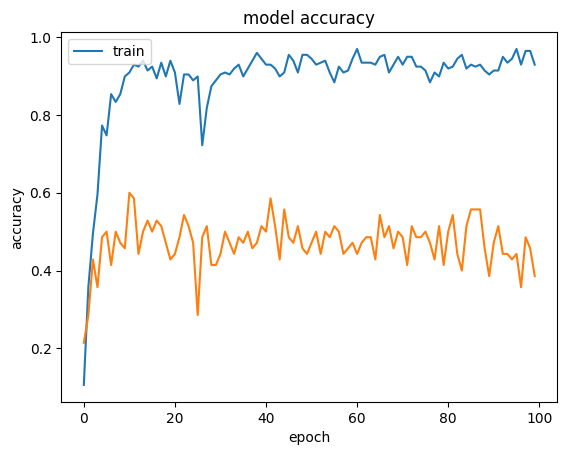

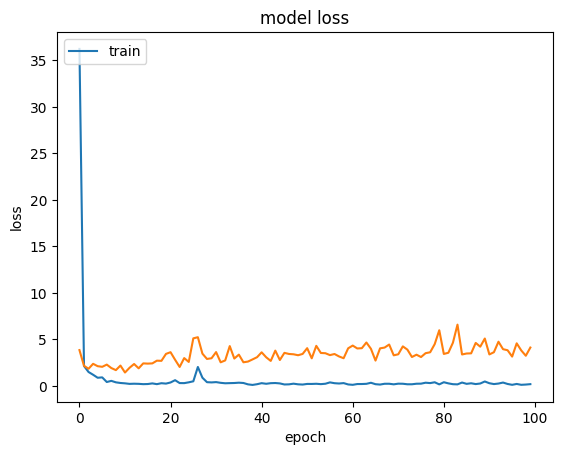

In [58]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# Loss function
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()